In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../../modules')

In [3]:
import numpy as np
import common_plots
import plotly.graph_objects as go

# Missing Data
Often input vectors are missing certain values. One approach to fix this issue is to simply discard all data with missing values. This si inefficient however. Other methods focus on accounting for the missing data instead or replacing it. The bayesian approach for is easy to derive with the product rule: <br>
$$
\begin{aligned}
    p(\theta|D_\text{obs})&=\int_{D_\text{mis}}p(\theta,D_\text{mis}|D_\text{obs}) \\
    &=\int_{D_\text{mis}}p(\theta|D_\text{obs},D_\text{mis})P(D_\text{mis}|D_\text{obs})
\end{aligned}
$$
What this requires is knowing $P(D_\text{mis}|D_\text{obs})$ and also integrating/summing out the unknowns. This can be computationally expensive. This Chapter looks at replacing data which has a random chance of being excluded.

### Data Imputation
One way to approach the problem is to use the maximum likelihood value of $P(D_\text{mis}|D_\text{obs})$ and then treat the problem as you would any problem with full data. There are cheap and more expensive ways of doing this. One very cheap option is to simply use the mean/mode/median value for a given variable.<br>
**Example:** A 2d MOG replacing $15\%$ of the values at random with the mean. First the MOG on its own. Sampling is done by selecting a gaussian with the weighting as the probability, then sampling and repeating. This is the same as generating samples proportional to the weighting in each. Say the first gaussian has a weight $0.3$ and the second has a weight $0.7$.

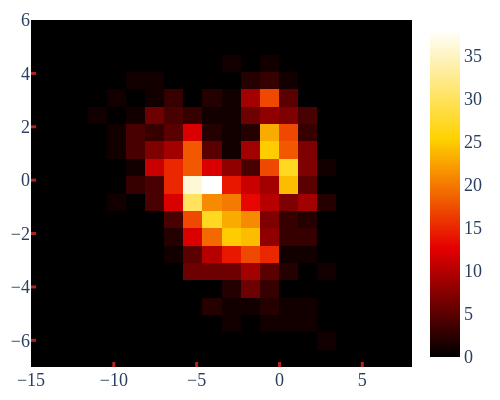

In [4]:
mean1,cov1 = [0,1],[[1,-0.6],[-0.6,2]]
mean2,cov2 = [-4,-1],[[4,-2],[-2,2.5]]
X1 = np.random.multivariate_normal(mean1,cov1,300)
X2 = np.random.multivariate_normal(mean2,cov2,700)
X = np.concatenate([X1,X2],axis=0)
# removing points
X_missing_indexes = np.random.rand(*X.shape)<0.50
X_missing = X.copy()
X_missing[X_missing_indexes]=np.nan
# remove where both values are nan
X_missing = X_missing[np.prod(np.isnan(X_missing),axis=1)==0]
# show original
fig_X = common_plots.plot_2D_Hist(X,20,[-15,8],[-7,6])
fig_X.show(renderer="png",width=500,height=400)

mean value imputing:

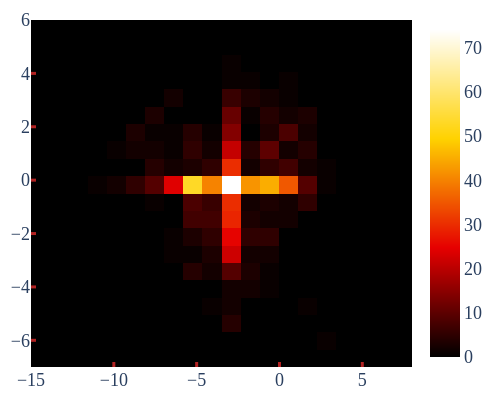

In [5]:
# impute values
X_impute_mean = X_missing.copy()
X_impute_mean[np.isnan(X_missing[:,0]),0]=np.nanmean(X_missing[:,0])
X_impute_mean[np.isnan(X_missing[:,1]),1]=np.nanmean(X_missing[:,1])
fig_mean_imputed_X = common_plots.plot_2D_Hist(X_impute_mean,20,[-15,8],[-7,6])
fig_mean_imputed_X.show(renderer="png",width=500,height=400)

Obviously this is a crude approximation. We do better by building a model of our data. For example we could fit a  gaussian to the data and draw conditional samples if one variable is known:

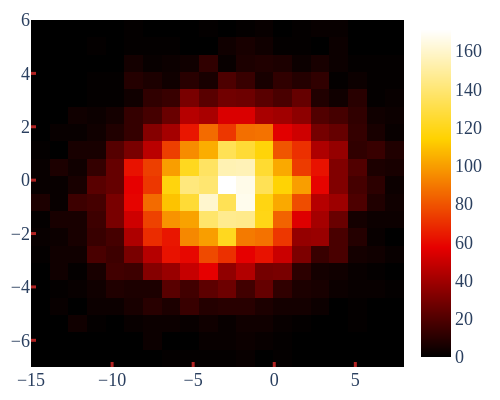

In [6]:
fit_gaus_mean = np.nanmean(X_missing,axis=0)
cov11 = np.nanmean(X_missing[:,0]*X_missing[:,0])
cov12= np.nanmean(X_missing[:,0]*X_missing[:,1])
cov21 = np.nanmean(X_missing[:,1]*X_missing[:,0])
cov22 = np.nanmean(X_missing[:,1]*X_missing[:,1])
fit_gaus_cov = np.array([[cov11,cov12],[cov21,cov22]])
fit_gaus_samples = np.random.multivariate_normal(fit_gaus_mean,fit_gaus_cov,10000)
fig_sph_fit = common_plots.plot_2D_Hist(fit_gaus_samples,20,[-15,8],[-7,6])
fig_sph_fit.show(renderer="png",width=500,height=400)

imputing with the above fit gaussian:

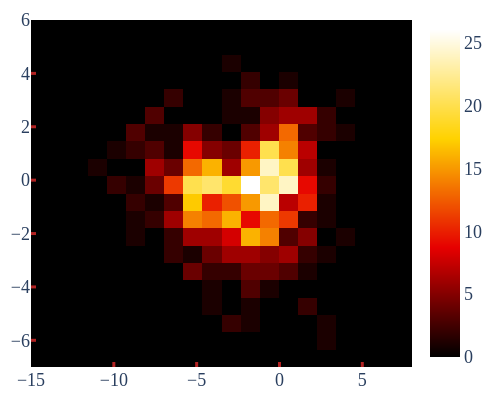

In [7]:
X_fit_gaussian_imputed = X_missing.copy()
for i in range(X_fit_gaussian_imputed.shape[0]):
    vec = X_fit_gaussian_imputed[i]
    if(np.isnan(vec[0]) and not np.isnan(vec[1])):
        cond_var = cov22-cov12*(1/cov22)*cov21
        cond_mean = fit_gaus_mean[1]+cov12*(1/cov22)*(vec[1]-fit_gaus_mean[1])
        new_X1_val = np.random.normal(cond_mean,np.sqrt(cond_var))
        X_fit_gaussian_imputed[i,0] = new_X1_val
    elif(np.isnan(vec[1]) and not np.isnan(vec[0])):
        cond_var = cov12-cov21*(1/cov11)*cov12
        cond_mean = fit_gaus_mean[1]+cov21*(1/cov11)*(vec[0]-fit_gaus_mean[0])
        new_X2_val = np.random.normal(cond_mean,np.sqrt(cond_var))
        X_fit_gaussian_imputed[i,1] = new_X2_val

fig_gaus_imputed_X = common_plots.plot_2D_Hist(X_fit_gaussian_imputed,20,[-15,8],[-7,6])
fig_gaus_imputed_X.show(renderer="png",width=500,height=400)

This gives a much better approximation. Another alternative is to use something like K-nearest-neighbours.

In [8]:
K = 10
X_KNN_imputed = X_missing.copy()
X_missing_none = X_missing[np.sum(np.isnan(X_missing),axis=1)==0]
for i in range(X_fit_gaussian_imputed.shape[0]):
    vec = X_missing[i]
    if(np.isnan(vec[0]) and not np.isnan(vec[1])):
        distancesX2 = (X_missing_none[:,1]-vec[1])**2
        shortest_K =  np.argsort(distancesX2)[:K]
        mean = np.mean(X_missing_none[shortest_K,0])
        X_KNN_imputed[i,0]=mean
    elif(not np.isnan(vec[0]) and np.isnan(vec[1])):
        distancesX1 = (X_missing_none[:,0]-vec[0])**2
        shortest_K =  np.argsort(distancesX1)[:K]
        mean = np.mean(X_missing_none[shortest_K,1])
        X_KNN_imputed[i,1]=mean

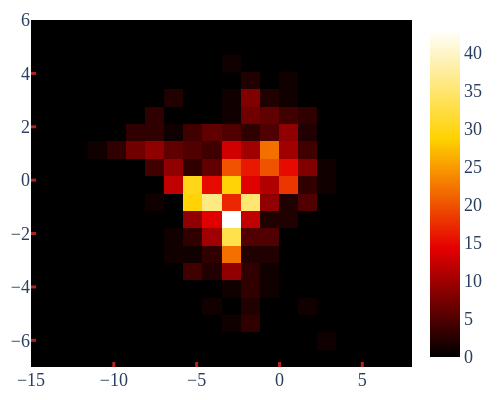

In [9]:
fig_KNN_imputed_X = common_plots.plot_2D_Hist(X_KNN_imputed,20,[-15,8],[-7,6])
fig_KNN_imputed_X.show(renderer="png",width=500,height=400)